# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 6 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

### Homework 6 is due April 10, 2019

In [1]:
# PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [3]:
import pyjags
import pandas as pd
from rpy2.robjects.packages import importr
r_utils = importr('utils')
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
r_coda = importr('coda')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from scipy.special import expit

In [4]:
from collections import Counter

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

Note that this has been tested with 
* pandas version 0.22.0
* rpy2 version 2.9.4

The latest libraries may have changed somewhat since these versions; if you are having problems, try using these versions.


<hr style="height:2pt">

### Problem 1: President Donald Trump's Tweets

In the first part of this assignment, you will be working with text from the @realDonaldTrump Twitter account. This consists of all tweets from the account from 5/4/2009 to 2/26/2019. The goal is to use Latent Dirichlet Allocation in order to model the topics tweeted about since President Trump's inauguration.

The dataset is from http://www.trumptwitterarchive.com/archive.

Start by reading the dataset into a pandas data frame.

In [5]:
df = pd.read_csv("data/trump_tweets.csv")

Now, extract only the rows since President Trump's inauguration on January 20, 2017 (you can use midnight on that date as the start time). You should use the datetime.strptime to convert dates to type `datetime`. Hint: first, you should remove any rows with missing timestamps.

In [6]:
df_clean = df.dropna(axis=0, how='any')
df_clean['created_at'] = pd.to_datetime(df_clean['created_at'], format='%m-%d-%Y %H:%M:%S')
df_clean = df_clean[df_clean.created_at >= "01-20-2017 00:00:00"]

Preprocess the data by making it all lowercase. Remove a reasonable set of stopwords from the dataset and tokenize. Then, report the 50 most common words and their count. You may need to iterate this process, adding some stop words as you understand the structure of the data. Justify additional stop words you've added.


In [7]:
import nltk
nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'[\w\']+') # \w means any letter or digit. 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/71387712/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Preprocess the data by default stop words
stop_words = set(stopwords.words('english'))
df_clean['text_clean'] = df_clean.text.str.lower()
df_clean['text_clean'] = df_clean['text_clean'].apply(tokenizer.tokenize)
df_clean['text_clean'] = df_clean['text_clean'].apply(lambda x: [cur_word for cur_word in x if cur_word not in stop_words])

# Show the top 50 common words 
total_counter = Counter()
for words in df_clean['text_clean']:
    word_count = Counter(words)
    total_counter += word_count
    
total_counter.most_common(50)

[('co', 2240),
 ('https', 2232),
 ('great', 1518),
 ('amp', 1152),
 ('rt', 1015),
 ('people', 789),
 ('president', 642),
 ('trump', 599),
 ('country', 568),
 ('news', 550),
 ('u', 512),
 ('fake', 495),
 ('big', 481),
 ('thank', 467),
 ('border', 467),
 ('democrats', 465),
 ('many', 464),
 ('today', 435),
 ('america', 416),
 ('get', 407),
 ('time', 394),
 ('new', 372),
 ('much', 338),
 ('would', 336),
 ('american', 335),
 ('realdonaldtrump', 328),
 ('good', 316),
 ('want', 316),
 ('years', 302),
 ('must', 302),
 ('never', 300),
 ('media', 295),
 ('security', 293),
 ('back', 287),
 ('vote', 284),
 ('wall', 283),
 ('one', 280),
 ('make', 278),
 ('jobs', 276),
 ('military', 272),
 ('united', 265),
 ('trade', 261),
 ('house', 260),
 ('states', 255),
 ('tax', 253),
 ('first', 251),
 ('job', 250),
 ('going', 247),
 ('election', 246),
 ('crime', 246)]

Justification: 
- There are some abbreviation words that show up as most common words, for example co, amp, u, rt, which do not carry any real meanings, so we decide to drop those words.
- @realDonaldTrump is the twitter account name, so we decide to drop it. 
- We noticed that 'Trump' is also a common word and it's Donald Trump's last name, but we decided to keep it because there are many other names show as common words like 'Obama' and 'Clinton'. These names do carry real meanings, so we kept them. 
- 'Great' as a word by itself carries positive meanings, but we decided to drop it since it almost appears in every Trump's tweet. 

In [9]:
# Preprocess the data by default stop words + Trump-specific words 
stop_words = set(stopwords.words('english'))
stop_words.update(['co', 'https', 'amp', 'rt', 'u', 'realdonaldtrump', 'great'])
df_clean['text_clean'] = df_clean.text.str.lower()
df_clean['text_clean'] = df_clean['text_clean'].apply(tokenizer.tokenize)
df_clean['text_clean'] = df_clean['text_clean'].apply(lambda x: [cur_word for cur_word in x if cur_word not in stop_words])

# Show the top 50 common words 
total_counter = Counter()
for words in df_clean['text_clean']:
    word_count = Counter(words)
    total_counter += word_count
    
total_counter.most_common(50)

[('people', 789),
 ('president', 642),
 ('trump', 599),
 ('country', 568),
 ('news', 550),
 ('fake', 495),
 ('big', 481),
 ('thank', 467),
 ('border', 467),
 ('democrats', 465),
 ('many', 464),
 ('today', 435),
 ('america', 416),
 ('get', 407),
 ('time', 394),
 ('new', 372),
 ('much', 338),
 ('would', 336),
 ('american', 335),
 ('good', 316),
 ('want', 316),
 ('years', 302),
 ('must', 302),
 ('never', 300),
 ('media', 295),
 ('security', 293),
 ('back', 287),
 ('vote', 284),
 ('wall', 283),
 ('one', 280),
 ('make', 278),
 ('jobs', 276),
 ('military', 272),
 ('united', 265),
 ('trade', 261),
 ('house', 260),
 ('states', 255),
 ('tax', 253),
 ('first', 251),
 ('job', 250),
 ('going', 247),
 ('election', 246),
 ('crime', 246),
 ('even', 245),
 ('state', 245),
 ('russia', 241),
 ('fbi', 238),
 ('done', 237),
 ('day', 234),
 ('working', 221)]

Find the optimal number of topics using the `u_mass` coherence measure. Plot the results; what does this plot suggest about the number of topics in the text?

In [10]:
masterdictionary = Dictionary(df_clean['text_clean'])
mastercorpus = [masterdictionary.doc2bow(doc) for doc in df_clean['text_clean']]

In [11]:
coherence_vals = []
for ntop in range(1, 10):
    mod = LdaModel(mastercorpus, num_topics=ntop, id2word=masterdictionary, passes=5, random_state=1)
    cmod = CoherenceModel(model=mod, corpus=mastercorpus, dictionary=masterdictionary, coherence='u_mass')
    cval = cmod.get_coherence()
    coherence_vals.append(cval)

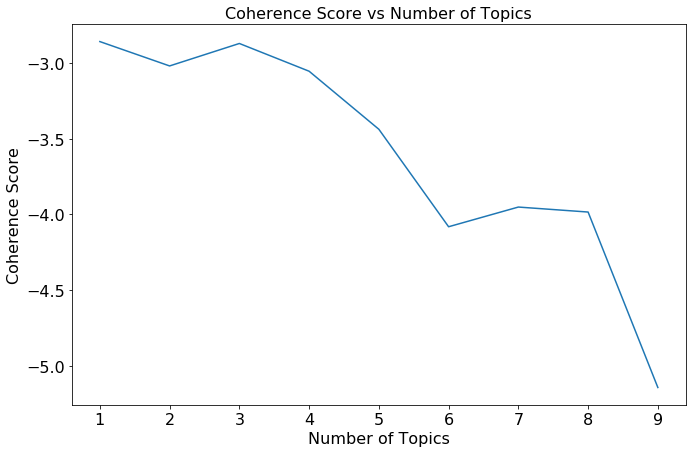

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(range(1,10), coherence_vals)
ax.set_title("Coherence Score vs Number of Topics", fontsize=16)
ax.set_xlabel("Number of Topics", fontsize=16)
ax.set_ylabel("Coherence Score", fontsize=16)
ax.tick_params(labelsize=16)

The number of topics in the text:
- The plot above suggests that there are 3 different topics in the text, as a value of k=3 maximized the coherence score. The results vary depending on the random seed though. 

Run LDA on the texts using the optimal value of $k$ found via your analysis above. Print out the top 10 words and associated betas for each of the $k$ topics. Comment on the results and their plausibility. What does each topic seem to represent?

In [13]:
num_topics = 3
model = LdaModel(mastercorpus, num_topics=num_topics, id2word=masterdictionary, passes=10, random_state=123)

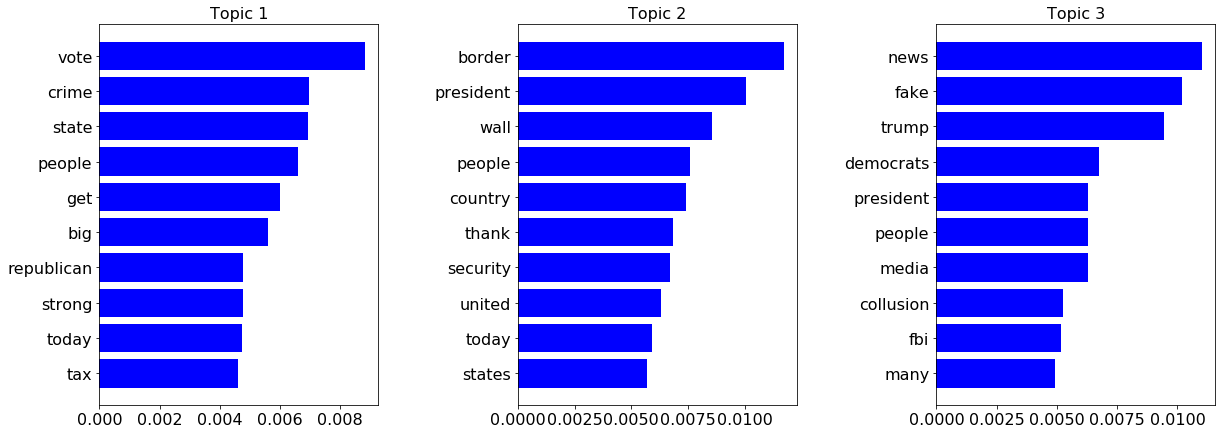

In [14]:
top_words = [[word for word,_ in model.show_topic(topicno, topn=50)] for topicno in range(model.num_topics)]
top_betas = [[beta for _,beta in model.show_topic(topicno, topn=50)] for topicno in range(model.num_topics)]

gs = plt.GridSpec(1,3)
gs.update(wspace=0.5, hspace=0.5)
plt.figure(figsize=(20, 7))
for i in range(num_topics):
    ax = plt.subplot(gs[i])
    plt.barh(range(10), top_betas[i][:10], align='center', color='blue', ecolor='black')
    ax.invert_yaxis()
    ax.set_yticks(range(10))
    ax.set_yticklabels(top_words[i][:10])
    ax.tick_params(labelsize=16)
    plt.title("Topic " + str(i + 1), fontsize=16)

**Summary**: Topic 1 seems to represent the campaign and election by mentioning words of republican, vote and tax. Topic 2 has to deal with Trump's border security by key words of border, wall, and security. Topic 3 is all about fake news related to FBI investigation. Overall, it seems that LDA did a good job of captureing the latent topics that are embedded within Trump's tweets.

### Problem 2: Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset-2-train.csv` and `dataset-2-test.csv` containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order.

In [15]:
df_train = pd.read_csv("data/dataset_2_train.csv")
df_test = pd.read_csv("data/dataset_2_test.csv")

In [16]:
df_train['district'] = df_train['district'].apply(lambda x: 54 if x == 61 else x)
df_test['district'] = df_test['district'].apply(lambda x: 54 if x == 61 else x)

In [17]:
df_train.head()

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


To verify the procedure, simulate binary response data assuming the following parameter values (and using the existing features and district information from the training data):

$\mu_{\beta_0} = 2$

$\sigma^2_{\beta_0} = 1$

$\beta_0 \sim N(\mu_{\beta_0},\sigma_{\beta_0}^2)$

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

In [18]:
mu_beta_0 = 2
sigma_beta_0 = 1
beta_0 = np.random.normal(mu_beta_0, sigma_beta_0, 60)
beta_1 = 4
beta_2 = -3 
beta_3 = -2

In [19]:
def sample_y(row):
    logit_pi = beta_0[int(row['district']) - 1] + (beta_1 * row['urban']) + (beta_2 * row['living.children']) +\
               (beta_3 * row['age_mean'])
    pi = np.exp(logit_pi)/(1 + np.exp(logit_pi))
    sample_y = np.random.binomial(1, pi, 1)
    
    return sample_y[0]

In [20]:
df_train['sample_y'] = df_train.apply(sample_y, axis=1)

In [21]:
df_train.describe()

,district,urban,living.children,age_mean,contraceptive_use,sample_y
count,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000
mean,29.513961,0.307135,2.591520,-0.310626,0.389866,0.476732
std,17.449470,0.461545,1.248457,8.995747,0.487972,0.499717
min,1.000000,0.000000,1.000000,-13.560000,0.000000,0.000000
25%,14.000000,0.000000,1.000000,-7.560000,0.000000,0.000000
50%,29.000000,0.000000,3.000000,-1.559900,0.000000,0.000000
75%,46.000000,1.000000,4.000000,6.440000,1.000000,1.000000
max,60.000000,1.000000,4.000000,19.440000,1.000000,1.000000


In [22]:
df_train.sample_y.value_counts()

0    506
1    461
Name: sample_y, dtype: int64

Fit the varying-intercept model specified above to your simulated data.

In [23]:
logistic_code = '''
model {       
    mu_beta_0 ~ dnorm(0, .0001)
    sigma2_beta_0_inv ~ dgamma(0.1, 0.1)
    sigma_beta_0 = sqrt(1/sigma2_beta_0_inv)
    
    for (j in 1:J) {
        beta_0[j] ~ dnorm(mu_beta_0, sigma2_beta_0_inv)
    }

    beta_1 ~ dnorm(0, .0001)
    beta_2 ~ dnorm(0, .0001)
    beta_3 ~ dnorm(0, .0001)
    
    for (i in 1:N) {
        pi[i] = ilogit(beta_0[district[i]] + beta_1 * urban[i] + beta_2 * living_children[i] + beta_3 * age_mean[i])
        y[i] ~ dbern(pi[i])
    }
}
'''

observed_vals = {'J': 60, 
                 'N': df_train.shape[0],
                 'district': df_train['district'],
                 'urban': df_train['urban'],
                 'living_children': df_train['living.children'],
                 'age_mean': df_train['age_mean'],
                 'y': df_train['sample_y']}

num_chains = 4
logistic_model = pyjags.Model(logistic_code, data=observed_vals, chains=num_chains)
burnin = logistic_model.sample(500)
samples = logistic_model.sample(2500) 

adapting: iterations 1252 of 4000, elapsed 0:00:06, remaining 0:00:13
adapting: iterations 2296 of 4000, elapsed 0:00:11, remaining 0:00:08
adapting: iterations 3324 of 4000, elapsed 0:00:16, remaining 0:00:03
adapting: iterations 4000 of 4000, elapsed 0:00:20, remaining 0:00:00
sampling: iterations 928 of 2000, elapsed 0:00:05, remaining 0:00:06
sampling: iterations 1852 of 2000, elapsed 0:00:10, remaining 0:00:01
sampling: iterations 2000 of 2000, elapsed 0:00:11, remaining 0:00:00
sampling: iterations 1960 of 10000, elapsed 0:00:10, remaining 0:00:41
sampling: iterations 3936 of 10000, elapsed 0:00:20, remaining 0:00:31
sampling: iterations 4924 of 10000, elapsed 0:00:26, remaining 0:00:27
sampling: iterations 5864 of 10000, elapsed 0:00:32, remaining 0:00:22
sampling: iterations 7724 of 10000, elapsed 0:00:41, remaining 0:00:12
sampling: iterations 8660 of 10000, elapsed 0:00:46, remaining 0:00:07
sampling: iterations 10000 of 10000, elapsed 0:00:53, remaining 0:00:00
sampling: ite

Plot the trace plots of the MCMC sampler for the parameters $\mu_{\beta_0}, \sigma_{\beta_0}, \beta_1, \beta_2, \beta_3$. Does it look like the samplers converged?

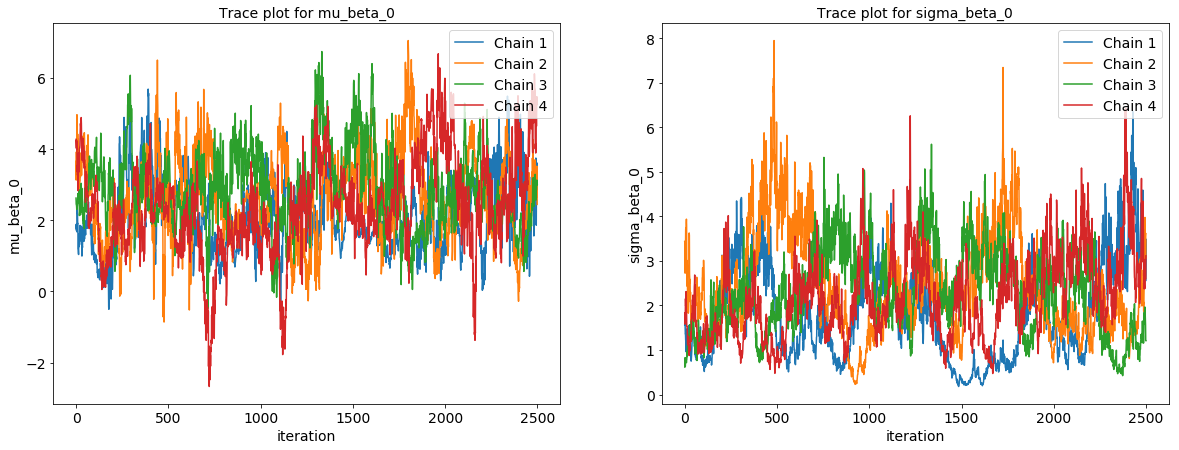

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(range(2500), samples['mu_beta_0'][0,:,0], label="Chain 1")
ax[0].plot(range(2500), samples['mu_beta_0'][0,:,1], label="Chain 2")
ax[0].plot(range(2500), samples['mu_beta_0'][0,:,2], label="Chain 3")
ax[0].plot(range(2500), samples['mu_beta_0'][0,:,3], label="Chain 4")
ax[0].set_xlabel("iteration", fontsize=14)
ax[0].set_ylabel("mu_beta_0", fontsize=14)
ax[0].set_title("Trace plot for mu_beta_0", fontsize=14)
ax[0].legend(loc='upper right', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,0], label="Chain 1")
ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,1], label="Chain 2")
ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,2], label="Chain 3")
ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,3], label="Chain 4")
ax[1].set_xlabel("iteration", fontsize=14)
ax[1].set_ylabel("sigma_beta_0", fontsize=14)
ax[1].set_title("Trace plot for sigma_beta_0", fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
ax[1].tick_params(labelsize=14)

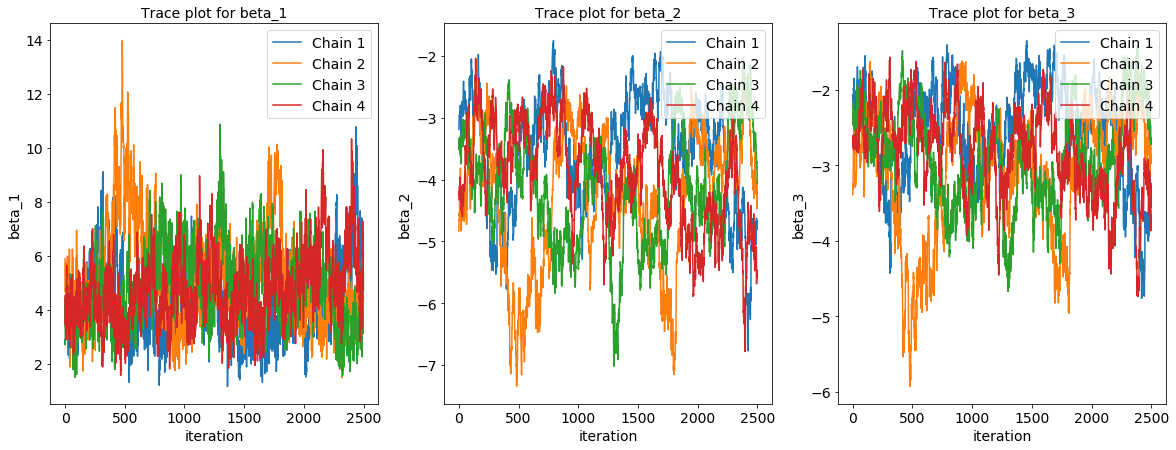

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(range(2500), samples['beta_1'][0,:,0], label="Chain 1")
ax[0].plot(range(2500), samples['beta_1'][0,:,1], label="Chain 2")
ax[0].plot(range(2500), samples['beta_1'][0,:,2], label="Chain 3")
ax[0].plot(range(2500), samples['beta_1'][0,:,3], label="Chain 4")
ax[0].set_xlabel("iteration", fontsize=14)
ax[0].set_ylabel("beta_1", fontsize=14)
ax[0].set_title("Trace plot for beta_1", fontsize=14)
ax[0].legend(loc='upper right', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(range(2500), samples['beta_2'][0,:,0], label="Chain 1")
ax[1].plot(range(2500), samples['beta_2'][0,:,1], label="Chain 2")
ax[1].plot(range(2500), samples['beta_2'][0,:,2], label="Chain 3")
ax[1].plot(range(2500), samples['beta_2'][0,:,3], label="Chain 4")
ax[1].set_xlabel("iteration", fontsize=14)
ax[1].set_ylabel("beta_2", fontsize=14)
ax[1].set_title("Trace plot for beta_2", fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
ax[1].tick_params(labelsize=14)

ax[2].plot(range(2500), samples['beta_3'][0,:,0], label="Chain 1")
ax[2].plot(range(2500), samples['beta_3'][0,:,1], label="Chain 2")
ax[2].plot(range(2500), samples['beta_3'][0,:,2], label="Chain 3")
ax[2].plot(range(2500), samples['beta_3'][0,:,3], label="Chain 4")
ax[2].set_xlabel("iteration", fontsize=14)
ax[2].set_ylabel("beta_3", fontsize=14)
ax[2].set_title("Trace plot for beta_3", fontsize=14)
ax[2].legend(loc='upper right', fontsize=14)
ax[2].tick_params(labelsize=14)

Yes, the trace plots above of MCMC sampler suggest that the samplers did converge, even though the convergence is not very good. The average of each chain looks roughly the same. 

Plot histograms of the posterior distributions for the parameters $\beta_{0,10}$, $\beta_{0,20}$,...,$\beta_{0,60}$. Are the actual parameters that you generated contained within these posterior distributions? 

In [26]:
def convert_to_dfs(samples, parameter_names, num_chains):
    """Converts a pyjags sampling result to a list of data frames, one per chain"""
    big_list = []
    for cur_chain_num in range(num_chains):
        df_list = []
        for k in parameter_names:
            v = samples[k]

            chain1_data = v[:,:,cur_chain_num]
            cur_df = pd.DataFrame(chain1_data.T)

            if cur_df.shape[1]==1:
                cur_df = cur_df.rename({0:k}, axis=1)
            else:
                cur_df = cur_df.add_prefix(k)

            df_list.append(cur_df)

        chain1_samples_df = pd.concat(df_list, axis=1)
        big_list.append(chain1_samples_df)
        
    return big_list

chain_df_list = convert_to_dfs(samples, ["mu_beta_0", "sigma_beta_0", "beta_1", "beta_2", "beta_3", "beta_0"], num_chains)
chain_df_list[0].head()

,mu_beta_0,sigma_beta_0,beta_1,beta_2,beta_3,beta_00,beta_01,beta_02,beta_03,beta_04,beta_05,beta_06,beta_07,beta_08,beta_09,beta_010,beta_011,beta_012,beta_013,beta_014,beta_015,beta_016,beta_017,beta_018,beta_019,beta_020,beta_021,beta_022,beta_023,beta_024,beta_025,beta_026,beta_027,beta_028,beta_029,beta_030,beta_031,beta_032,beta_033,beta_034,beta_035,beta_036,beta_037,beta_038,beta_039,beta_040,beta_041,beta_042,beta_043,beta_044,beta_045,beta_046,beta_047,beta_048,beta_049,beta_050,beta_051,beta_052,beta_053,beta_054,beta_055,beta_056,beta_057,beta_058,beta_059
0,1.778924,1.566492,4.177744,-3.187474,-2.205451,1.678605,2.447637,2.433281,0.152057,2.353050,3.936539,3.059792,2.760254,2.189833,-0.567859,3.074307,-0.985048,3.811693,0.412638,1.459303,1.391167,2.163907,3.543986,-1.682085,2.894329,-0.879924,4.668142,3.350705,1.377699,2.543855,1.791615,4.392972,2.799169,4.869366,-1.112552,0.818714,0.238482,1.691058,2.691215,2.011025,4.714758,0.050421,-0.086870,0.524857,2.149219,-1.204332,1.430521,2.743871,3.102456,2.607037,1.425847,1.079253,1.578606,0.399021,-0.031521,2.711732,1.788672,-0.658471,3.835874,-1.668136,1.063779,2.699477,1.705752,2.876102,4.235250
1,1.882951,1.768847,4.076797,-3.052401,-2.256703,1.850027,0.663144,2.679977,2.676795,2.950140,2.962913,1.774996,5.771881,1.711709,3.566864,1.507475,-0.763857,-1.595328,5.779429,-1.893400,0.614946,2.436255,3.516239,1.256350,3.812675,0.875426,3.210679,3.403143,-0.198256,3.536008,2.772154,2.598487,-0.034896,-1.289285,-0.033320,3.233372,0.204163,1.160225,2.527316,0.984262,2.381900,-1.021936,0.704855,0.191655,0.415643,-0.285900,1.117762,-0.001263,2.823120,1.186515,0.607408,1.847535,1.516160,1.487528,-0.784391,2.593820,1.000432,-0.174656,2.037568,0.302697,-0.040834,3.696940,0.884052,3.539605,3.813470
2,1.715427,1.522931,3.960086,-3.019215,-2.064015,1.599185,1.627030,3.211634,1.187510,2.533915,3.328015,1.844405,4.846116,3.879900,2.550999,1.198668,-0.783482,1.213127,4.175104,-1.435229,2.499777,4.074921,1.979981,-0.549372,1.398201,-1.989565,3.439817,-1.106641,-0.560971,1.010838,1.310010,4.256913,1.719655,1.079683,0.887223,1.979721,1.254325,2.442583,2.269041,2.632175,4.433821,-1.516073,0.785875,3.466672,0.987494,1.233674,2.175890,2.288960,4.402773,0.644267,0.761855,0.392583,-0.993405,0.261826,4.579739,2.750369,2.937346,-0.329150,2.251817,2.867267,2.190631,0.324057,1.074738,0.453177,4.647837
3,1.741656,1.362565,4.079711,-2.990201,-2.120836,0.950356,3.111650,1.336742,1.443734,1.117865,2.162169,2.164424,3.397915,2.210718,0.508249,0.435764,0.570731,2.134989,3.250156,0.885921,2.280624,4.170495,3.190868,0.668832,0.597989,-0.338520,3.352080,-0.908633,3.838163,1.744565,2.838488,2.269080,0.489313,2.483554,2.220088,0.374574,1.602333,0.944695,0.231463,2.730780,4.259167,-1.163980,2.541962,3.779435,1.151652,1.781388,2.460072,2.427460,2.534673,1.929638,0.975161,0.172580,0.188019,1.588542,2.461018,3.194734,0.169737,-1.008477,3.435218,1.691527,2.336977,1.930737,1.085658,2.501582,5.153178
4,1.673489,1.365402,4.012822,-2.956839,-2.142717,0.645661,2.861836,3.113933,1.617198,1.163692,4.323928,0.087334,3.888967,3.535605,-0.699170,-0.082725,1.987203,1.772334,2.809452,0.495199,-0.157557,3.138592,1.945004,-0.389151,0.954161,2.303082,3.255643,-0.099785,2.705227,2.417598,1.518493,3.574855,1.459832,2.945171,-0.852325,1.875234,1.855315,1.664568,2.145610,4.148787,1.218970,2.656956,1.379547,2.367476,0.502233,2.056725,2.348182,2.629989,0.921751,3.356812,0.749712,2.229719,1.422683,1.780666,2.233525,0.668613,1.808090,0.254781,3.975173,1.094813,2.643352,-0.885655,0.731911,0.033434,6.092316


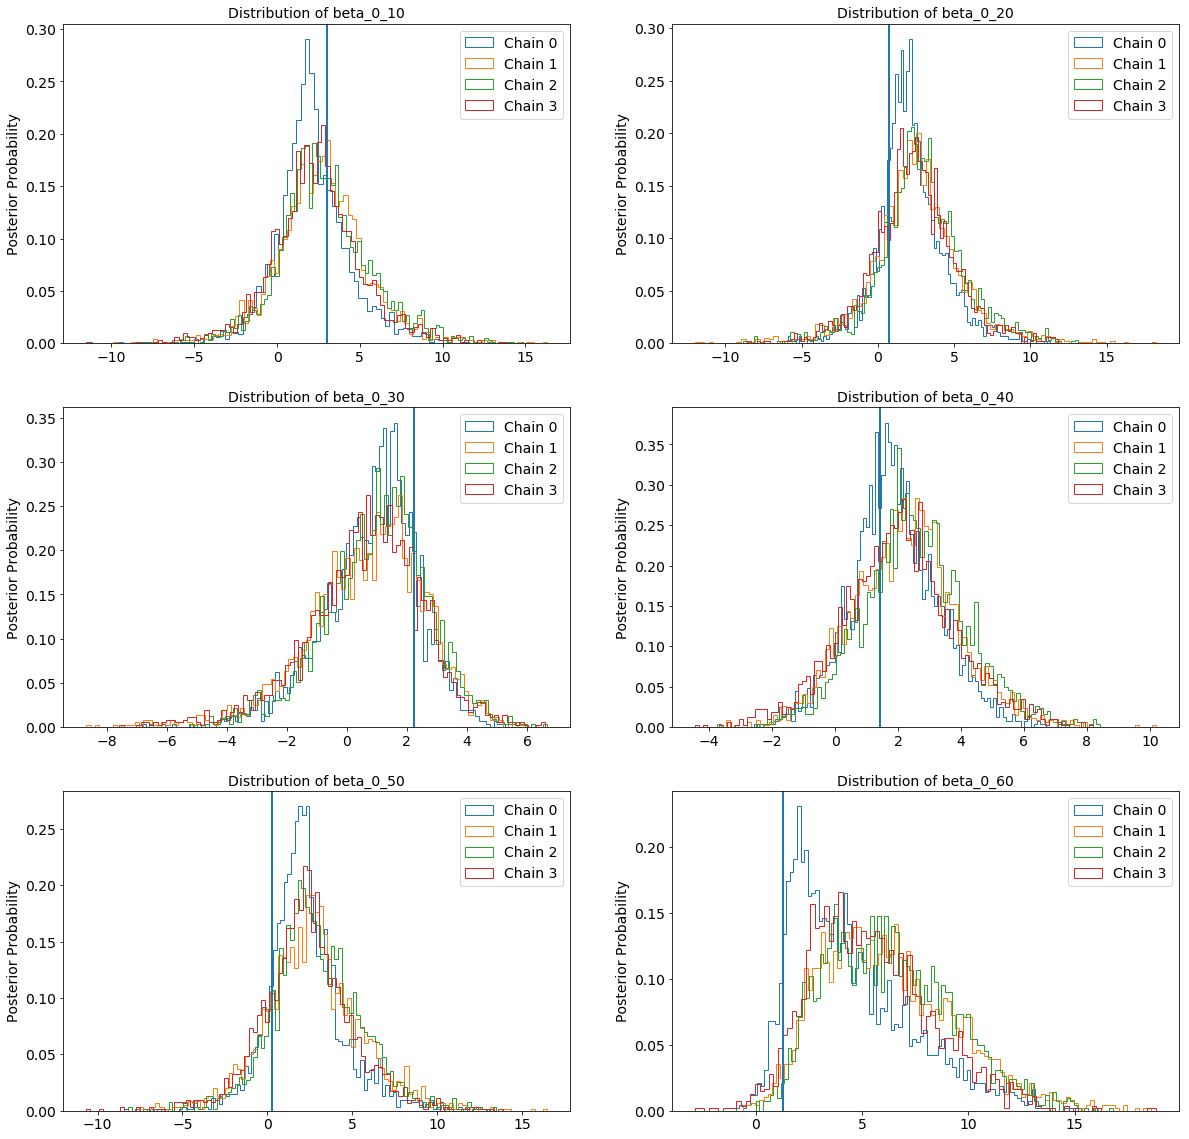

In [27]:
beta_0_col = ['beta_09', 'beta_019', 'beta_029', 'beta_039', 'beta_049', 'beta_059']
beta_0_label = ['beta_0_10', 'beta_0_20', 'beta_0_30', 'beta_0_40', 'beta_0_50', 'beta_0_60']
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
ax = ax.ravel()

for i in range(6):
    for cur_chain in range(num_chains):
        col = beta_0_col[i]
        label = beta_0_label[i]
        ax[i].hist(chain_df_list[cur_chain][col], bins=100, 
                   histtype='step', density=True, label="Chain {}".format(cur_chain))
        ax[i].legend(loc='upper right', fontsize=14)
        ax[i].axvline(x=beta_0[i * 10 - 1])
        
    ax[i].set_title("Distribution of %s" % label, fontsize=14)
    ax[i].set_ylabel("Posterior Probability", fontsize=14)
    ax[i].tick_params(labelsize=14)

Yes, all actual parameters are contained within these posterior distributions, as shown above. This is a good sign, because it means the model is ready for real data. Granted, some predictions are slightly biased, but all estimates are vaild draws from posterior distributions.

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [28]:
observed_vals = {'J': 60, 
                 'N': df_train.shape[0],
                 'district': df_train['district'],
                 'urban': df_train['urban'],
                 'living_children': df_train['living.children'],
                 'age_mean': df_train['age_mean'],
                 'y': df_train['contraceptive_use']}

num_chains = 4
logistic_model = pyjags.Model(logistic_code, data=observed_vals, chains=num_chains)
burnin = logistic_model.sample(500)
samples = logistic_model.sample(2500) 

adapting: iterations 2208 of 4000, elapsed 0:00:09, remaining 0:00:08
adapting: iterations 4000 of 4000, elapsed 0:00:17, remaining 0:00:00
adapting: iterations 4000 of 4000, elapsed 0:00:17, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 2148 of 10000, elapsed 0:00:10, remaining 0:00:35
sampling: iterations 4396 of 10000, elapsed 0:00:20, remaining 0:00:25
sampling: iterations 6644 of 10000, elapsed 0:00:29, remaining 0:00:15
sampling: iterations 8892 of 10000, elapsed 0:00:40, remaining 0:00:05
sampling: iterations 10000 of 10000, elapsed 0:00:45, remaining 0:00:00


Check the convergence by examining the trace plots, as you did with the simulated data. What do you observe?

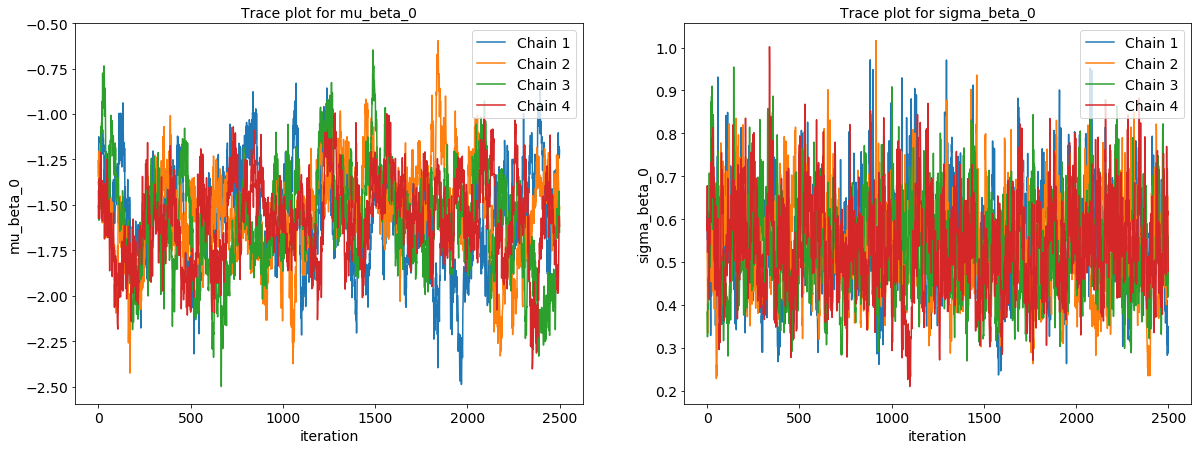

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(range(2500), samples['mu_beta_0'][0,:,0], label="Chain 1")
ax[0].plot(range(2500), samples['mu_beta_0'][0,:,1], label="Chain 2")
ax[0].plot(range(2500), samples['mu_beta_0'][0,:,2], label="Chain 3")
ax[0].plot(range(2500), samples['mu_beta_0'][0,:,3], label="Chain 4")
ax[0].set_xlabel("iteration", fontsize=14)
ax[0].set_ylabel("mu_beta_0", fontsize=14)
ax[0].set_title("Trace plot for mu_beta_0", fontsize=14)
ax[0].legend(loc='upper right', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,0], label="Chain 1")
ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,1], label="Chain 2")
ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,2], label="Chain 3")
ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,3], label="Chain 4")
ax[1].set_xlabel("iteration", fontsize=14)
ax[1].set_ylabel("sigma_beta_0", fontsize=14)
ax[1].set_title("Trace plot for sigma_beta_0", fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
ax[1].tick_params(labelsize=14)

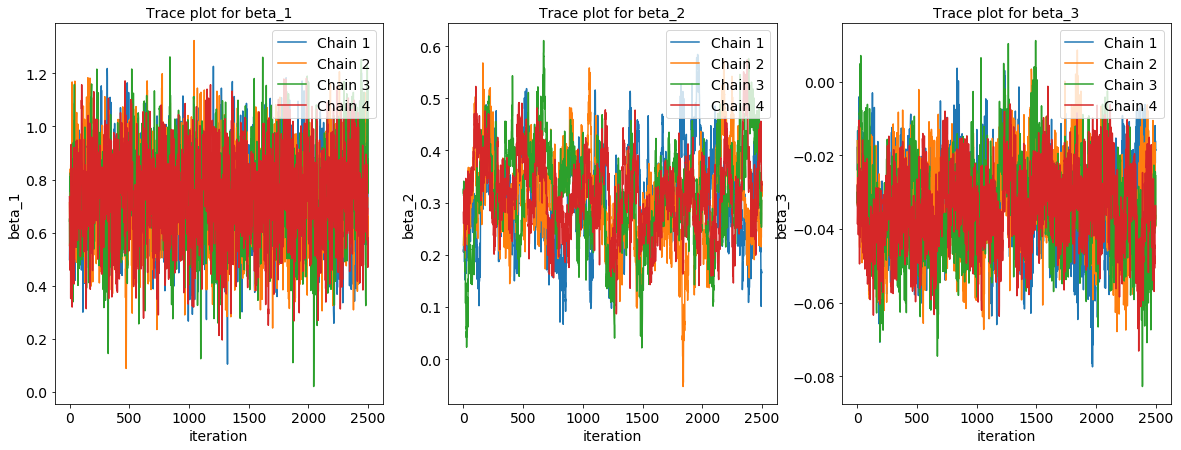

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(range(2500), samples['beta_1'][0,:,0], label="Chain 1")
ax[0].plot(range(2500), samples['beta_1'][0,:,1], label="Chain 2")
ax[0].plot(range(2500), samples['beta_1'][0,:,2], label="Chain 3")
ax[0].plot(range(2500), samples['beta_1'][0,:,3], label="Chain 4")
ax[0].set_xlabel("iteration", fontsize=14)
ax[0].set_ylabel("beta_1", fontsize=14)
ax[0].set_title("Trace plot for beta_1", fontsize=14)
ax[0].legend(loc='upper right', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(range(2500), samples['beta_2'][0,:,0], label="Chain 1")
ax[1].plot(range(2500), samples['beta_2'][0,:,1], label="Chain 2")
ax[1].plot(range(2500), samples['beta_2'][0,:,2], label="Chain 3")
ax[1].plot(range(2500), samples['beta_2'][0,:,3], label="Chain 4")
ax[1].set_xlabel("iteration", fontsize=14)
ax[1].set_ylabel("beta_2", fontsize=14)
ax[1].set_title("Trace plot for beta_2", fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
ax[1].tick_params(labelsize=14)

ax[2].plot(range(2500), samples['beta_3'][0,:,0], label="Chain 1")
ax[2].plot(range(2500), samples['beta_3'][0,:,1], label="Chain 2")
ax[2].plot(range(2500), samples['beta_3'][0,:,2], label="Chain 3")
ax[2].plot(range(2500), samples['beta_3'][0,:,3], label="Chain 4")
ax[2].set_xlabel("iteration", fontsize=14)
ax[2].set_ylabel("beta_3", fontsize=14)
ax[2].set_title("Trace plot for beta_3", fontsize=14)
ax[2].legend(loc='upper right', fontsize=14)
ax[2].tick_params(labelsize=14)

It looks like that the samplers have converged, since none of the chains diverge from one another.

Based on the posterior means, women belonging to which district are most likely to use contraceptives? Women belonging to which district are least likely to use contraceptives?

In [31]:
chain_df_list = convert_to_dfs(samples, ["beta_0"], num_chains)

chain_df_total = pd.DataFrame()
for i in range(num_chains): 
    if i == 0: 
        chain_df_total = chain_df_list[i]
    else: 
        chain_df_total = chain_df_total.append(chain_df_list[i], ignore_index=True)
        
chain_df_mean = chain_df_total.mean()      

district_max = int(chain_df_mean.idxmax().replace('beta_0','')) + 1
district_min = int(chain_df_mean.idxmin().replace('beta_0','')) + 1
print("Women belonging to %s district are most likely to use contraceptives." % district_max)
print("Women belonging to %s district are least likely to use contraceptives." % district_min)

Women belonging to 56 district are most likely to use contraceptives.
Women belonging to 11 district are least likely to use contraceptives.


Women beloning to 56 district are most likely to use contraceptives, and women belonging to 11 district are least likely to use contraceptives.

What are the posterior means of $\mu_{\beta_0}$ and $\sigma^2_{\beta_0}$? Do these values offer any evidence in support of or against the varying-intercept model?

In [32]:
chain_df_list = convert_to_dfs(samples, ["mu_beta_0", "sigma_beta_0"], num_chains)

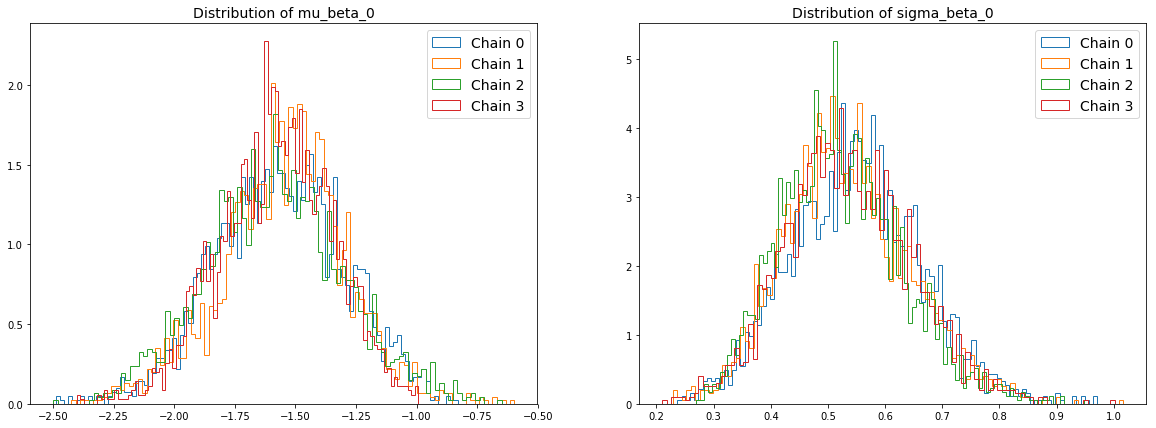

In [33]:
columns = ['mu_beta_0', 'sigma_beta_0']
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax = ax.ravel()

for i in range(2):
    for cur_chain in range(num_chains):
        col = columns[i]
        ax[i].hist(chain_df_list[cur_chain][col], bins=100, 
                   histtype='step', density=True, label="Chain {}".format(cur_chain))
        ax[i].legend(loc='upper right', fontsize=14)
        ax[i].set_title("Distribution of %s" % col, fontsize=14)

In [34]:
chain_df_total = pd.DataFrame()
for i in range(num_chains): 
    if i == 0: 
        chain_df_total = chain_df_list[i]
    else: 
        chain_df_total = chain_df_total.append(chain_df_list[i], ignore_index=True)
        
chain_df_mean = chain_df_total.mean()      
print("Posterior mean of mu: %.2f" % chain_df_mean['mu_beta_0'])
print("Posterior mean of sigma: %.2f" % chain_df_mean['sigma_beta_0'])
print("Posterior mean of variance: %.2f" % pow(chain_df_mean['sigma_beta_0'],2))

Posterior mean of mu: -1.57
Posterior mean of sigma: 0.54
Posterior mean of variance: 0.29


Since the posterior means of mu and sigma are not 0, we have evidence supporting the hypothesis that the contraceptive usage varies by district. Based on the above charts, we can confirm that 0 is far in the tails of the posterior distributions.

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [35]:
logistic_code2 = '''
model {       
    mu_beta_0 ~ dnorm(0, .0001)
    sigma2_beta_0_inv ~ dgamma(0.1, 0.1)
    sigma2_beta_1_inv ~ dgamma(0.1, 0.1)
    sigma2_beta_2_inv ~ dgamma(0.1, 0.1)
    sigma2_beta_3_inv ~ dgamma(0.1, 0.1)
    sigma_beta_0 = sqrt(1/sigma2_beta_0_inv)
    sigma_beta_1 = sqrt(1/sigma2_beta_1_inv)
    sigma_beta_2 = sqrt(1/sigma2_beta_2_inv)
    sigma_beta_3 = sqrt(1/sigma2_beta_3_inv)
    
    for (j in 1:J) {
        beta_0[j] ~ dnorm(mu_beta_0, sigma2_beta_0_inv)
        beta_1[j] ~ dnorm(0, sigma2_beta_1_inv)
        beta_2[j] ~ dnorm(0, sigma2_beta_2_inv)
        beta_3[j] ~ dnorm(0, sigma2_beta_3_inv)
    }
    
    for (i in 1:N) {
        pi[i] = ilogit(beta_0[district[i]] + beta_1[district[i]] * urban[i] + beta_2[district[i]] * living_children[i] + beta_3[district[i]] * age_mean[i])
        y[i] ~ dbern(pi[i])
    }
}
'''

observed_vals = {'J': 60, 
                 'N': df_train.shape[0],
                 'district': df_train['district'],
                 'urban': df_train['urban'],
                 'living_children': df_train['living.children'],
                 'age_mean': df_train['age_mean'],
                 'y': df_train['contraceptive_use']}

num_chains = 4
logistic_model = pyjags.Model(logistic_code2, data=observed_vals, chains=num_chains)
burnin = logistic_model.sample(500)
samples = logistic_model.sample(2500) 

adapting: iterations 2128 of 4000, elapsed 0:00:06, remaining 0:00:05
adapting: iterations 4000 of 4000, elapsed 0:00:11, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 3372 of 10000, elapsed 0:00:10, remaining 0:00:19
sampling: iterations 5132 of 10000, elapsed 0:00:15, remaining 0:00:14
sampling: iterations 6884 of 10000, elapsed 0:00:20, remaining 0:00:09
sampling: iterations 8628 of 10000, elapsed 0:00:25, remaining 0:00:04
sampling: iterations 10000 of 10000, elapsed 0:00:29, remaining 0:00:00


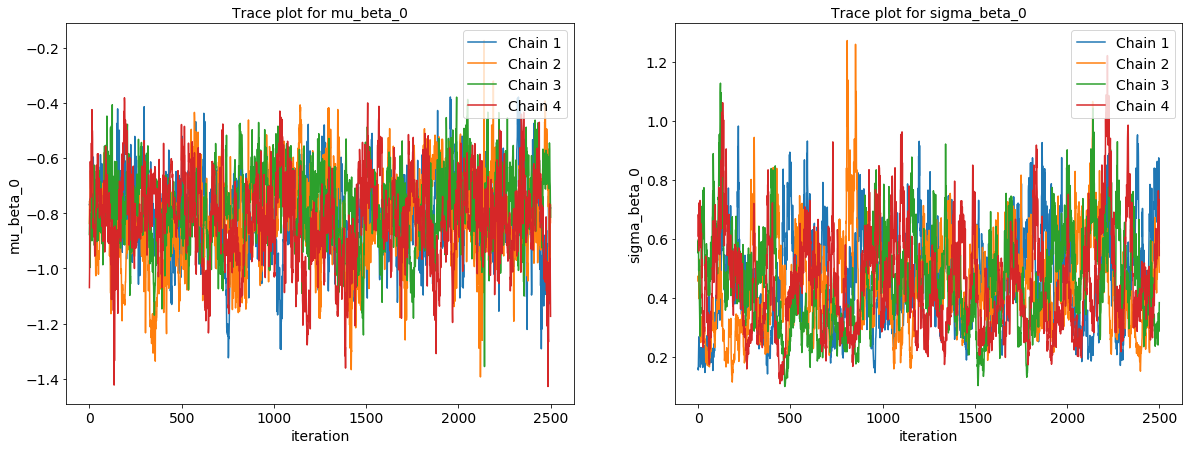

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(range(2500), samples['mu_beta_0'][0,:,0], label="Chain 1")
ax[0].plot(range(2500), samples['mu_beta_0'][0,:,1], label="Chain 2")
ax[0].plot(range(2500), samples['mu_beta_0'][0,:,2], label="Chain 3")
ax[0].plot(range(2500), samples['mu_beta_0'][0,:,3], label="Chain 4")
ax[0].set_xlabel("iteration", fontsize=14)
ax[0].set_ylabel("mu_beta_0", fontsize=14)
ax[0].set_title("Trace plot for mu_beta_0", fontsize=14)
ax[0].legend(loc='upper right', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,0], label="Chain 1")
ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,1], label="Chain 2")
ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,2], label="Chain 3")
ax[1].plot(range(2500), samples['sigma_beta_0'][0,:,3], label="Chain 4")
ax[1].set_xlabel("iteration", fontsize=14)
ax[1].set_ylabel("sigma_beta_0", fontsize=14)
ax[1].set_title("Trace plot for sigma_beta_0", fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
ax[1].tick_params(labelsize=14)

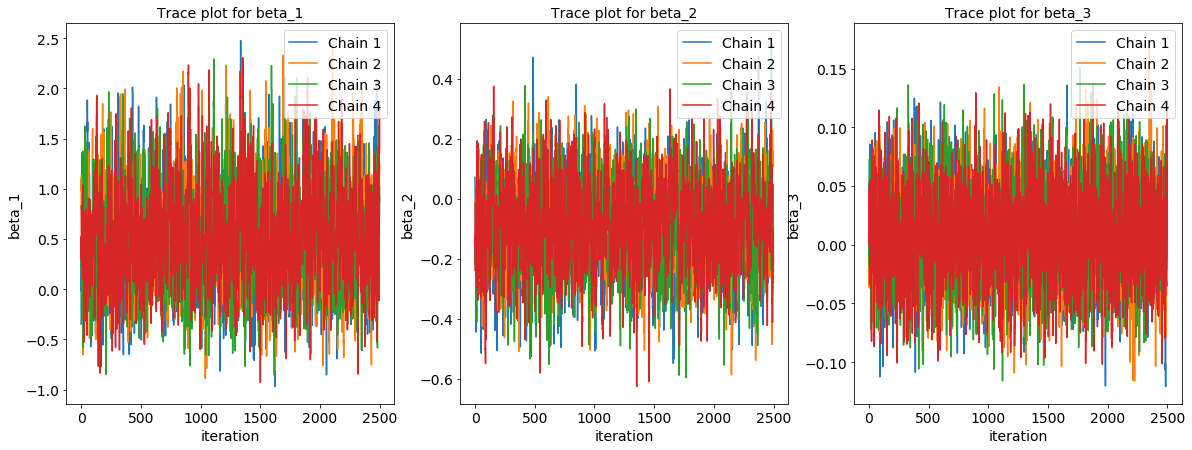

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(range(2500), samples['beta_1'][0,:,0], label="Chain 1")
ax[0].plot(range(2500), samples['beta_1'][0,:,1], label="Chain 2")
ax[0].plot(range(2500), samples['beta_1'][0,:,2], label="Chain 3")
ax[0].plot(range(2500), samples['beta_1'][0,:,3], label="Chain 4")
ax[0].set_xlabel("iteration", fontsize=14)
ax[0].set_ylabel("beta_1", fontsize=14)
ax[0].set_title("Trace plot for beta_1", fontsize=14)
ax[0].legend(loc='upper right', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(range(2500), samples['beta_2'][0,:,0], label="Chain 1")
ax[1].plot(range(2500), samples['beta_2'][0,:,1], label="Chain 2")
ax[1].plot(range(2500), samples['beta_2'][0,:,2], label="Chain 3")
ax[1].plot(range(2500), samples['beta_2'][0,:,3], label="Chain 4")
ax[1].set_xlabel("iteration", fontsize=14)
ax[1].set_ylabel("beta_2", fontsize=14)
ax[1].set_title("Trace plot for beta_2", fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
ax[1].tick_params(labelsize=14)

ax[2].plot(range(2500), samples['beta_3'][0,:,0], label="Chain 1")
ax[2].plot(range(2500), samples['beta_3'][0,:,1], label="Chain 2")
ax[2].plot(range(2500), samples['beta_3'][0,:,2], label="Chain 3")
ax[2].plot(range(2500), samples['beta_3'][0,:,3], label="Chain 4")
ax[2].set_xlabel("iteration", fontsize=14)
ax[2].set_ylabel("beta_3", fontsize=14)
ax[2].set_title("Trace plot for beta_3", fontsize=14)
ax[2].legend(loc='upper right', fontsize=14)
ax[2].tick_params(labelsize=14)

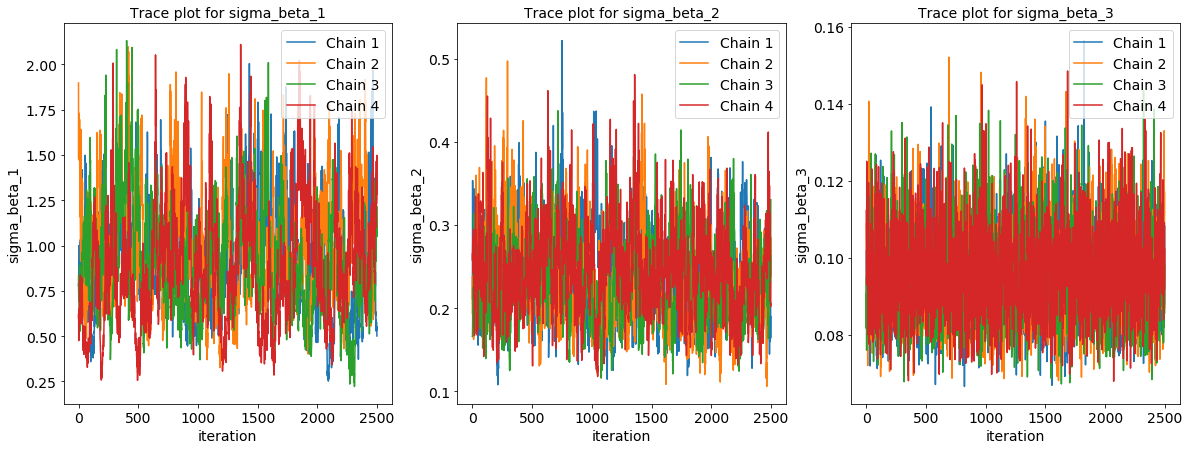

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].plot(range(2500), samples['sigma_beta_1'][0,:,0], label="Chain 1")
ax[0].plot(range(2500), samples['sigma_beta_1'][0,:,1], label="Chain 2")
ax[0].plot(range(2500), samples['sigma_beta_1'][0,:,2], label="Chain 3")
ax[0].plot(range(2500), samples['sigma_beta_1'][0,:,3], label="Chain 4")
ax[0].set_xlabel("iteration", fontsize=14)
ax[0].set_ylabel("sigma_beta_1", fontsize=14)
ax[0].set_title("Trace plot for sigma_beta_1", fontsize=14)
ax[0].legend(loc='upper right', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(range(2500), samples['sigma_beta_2'][0,:,0], label="Chain 1")
ax[1].plot(range(2500), samples['sigma_beta_2'][0,:,1], label="Chain 2")
ax[1].plot(range(2500), samples['sigma_beta_2'][0,:,2], label="Chain 3")
ax[1].plot(range(2500), samples['sigma_beta_2'][0,:,3], label="Chain 4")
ax[1].set_xlabel("iteration", fontsize=14)
ax[1].set_ylabel("sigma_beta_2", fontsize=14)
ax[1].set_title("Trace plot for sigma_beta_2", fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
ax[1].tick_params(labelsize=14)

ax[2].plot(range(2500), samples['sigma_beta_3'][0,:,0], label="Chain 1")
ax[2].plot(range(2500), samples['sigma_beta_3'][0,:,1], label="Chain 2")
ax[2].plot(range(2500), samples['sigma_beta_3'][0,:,2], label="Chain 3")
ax[2].plot(range(2500), samples['sigma_beta_3'][0,:,3], label="Chain 4")
ax[2].set_xlabel("iteration", fontsize=14)
ax[2].set_ylabel("sigma_beta_3", fontsize=14)
ax[2].set_title("Trace plot for sigma_beta_3", fontsize=14)
ax[2].legend(loc='upper right', fontsize=14)
ax[2].tick_params(labelsize=14)

In [39]:
# chain 1
normal_chain1 = np.column_stack((samples['mu_beta_0'][0][:,0], 
                                 samples['sigma_beta_0'][0][:,0],
                                 samples['beta_1'][0][:,0],
                                 samples['beta_2'][0][:,0],
                                 samples['beta_3'][0][:,0],
                                 samples['sigma_beta_1'][0][:,0],
                                 samples['sigma_beta_2'][0][:,0],
                                 samples['sigma_beta_3'][0][:,0]))
normal_chain1_df = pd.DataFrame({'mu_beta_0':normal_chain1[:,0], 
                                 'sigma_beta_0':normal_chain1[:,1],
                                 'beta_1':normal_chain1[:,2], 
                                 'beta_2':normal_chain1[:,3], 
                                 'beta_3':normal_chain1[:,4], 
                                 'sigma_beta_1':normal_chain1[:,5], 
                                 'sigma_beta_2':normal_chain1[:,6], 
                                 'sigma_beta_3':normal_chain1[:,7]})
normal_chain1_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain1_df))

# chain 2
normal_chain2 = np.column_stack((samples['mu_beta_0'][0][:,1], 
                                 samples['sigma_beta_0'][0][:,1],
                                 samples['beta_1'][0][:,1],
                                 samples['beta_2'][0][:,1],
                                 samples['beta_3'][0][:,1],
                                 samples['sigma_beta_1'][0][:,1],
                                 samples['sigma_beta_2'][0][:,1],
                                 samples['sigma_beta_3'][0][:,1]))
normal_chain2_df = pd.DataFrame({'mu_beta_0':normal_chain2[:,0], 
                                 'sigma_beta_0':normal_chain2[:,1],
                                 'beta_1':normal_chain2[:,2], 
                                 'beta_2':normal_chain2[:,3], 
                                 'beta_3':normal_chain2[:,4], 
                                 'sigma_beta_1':normal_chain2[:,5], 
                                 'sigma_beta_2':normal_chain2[:,6], 
                                 'sigma_beta_3':normal_chain2[:,7]})
normal_chain2_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain2_df))

# chain 3
normal_chain3 = np.column_stack((samples['mu_beta_0'][0][:,2], 
                                 samples['sigma_beta_0'][0][:,2],
                                 samples['beta_1'][0][:,2],
                                 samples['beta_2'][0][:,2],
                                 samples['beta_3'][0][:,2],
                                 samples['sigma_beta_1'][0][:,2],
                                 samples['sigma_beta_2'][0][:,2],
                                 samples['sigma_beta_3'][0][:,2]))
normal_chain3_df = pd.DataFrame({'mu_beta_0':normal_chain3[:,0], 
                                 'sigma_beta_0':normal_chain3[:,1],
                                 'beta_1':normal_chain3[:,2], 
                                 'beta_2':normal_chain3[:,3], 
                                 'beta_3':normal_chain3[:,4], 
                                 'sigma_beta_1':normal_chain3[:,5], 
                                 'sigma_beta_2':normal_chain3[:,6], 
                                 'sigma_beta_3':normal_chain3[:,7]})
normal_chain3_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain3_df))

# chain 4
normal_chain4 = np.column_stack((samples['mu_beta_0'][0][:,3], 
                                 samples['sigma_beta_0'][0][:,3],
                                 samples['beta_1'][0][:,3],
                                 samples['beta_2'][0][:,3],
                                 samples['beta_3'][0][:,3],
                                 samples['sigma_beta_1'][0][:,3],
                                 samples['sigma_beta_2'][0][:,3],
                                 samples['sigma_beta_3'][0][:,3]))
normal_chain4_df = pd.DataFrame({'mu_beta_0':normal_chain4[:,0], 
                                 'sigma_beta_0':normal_chain4[:,1],
                                 'beta_1':normal_chain4[:,2], 
                                 'beta_2':normal_chain4[:,3], 
                                 'beta_3':normal_chain4[:,4], 
                                 'sigma_beta_1':normal_chain4[:,5], 
                                 'sigma_beta_2':normal_chain4[:,6], 
                                 'sigma_beta_3':normal_chain4[:,7]})
normal_chain4_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain4_df))

# convert to mcmc_list object
normal_chains = r_coda.mcmc_list(normal_chain1_mcmc, 
                                 normal_chain2_mcmc,
                                 normal_chain3_mcmc,
                                 normal_chain4_mcmc)

# get n_eff and Rhat
normal_n_eff = np.round(np.array(r_coda.effectiveSize(normal_chains))) #round because must be an integer
normal_rhat = np.array(r_coda.gelman_diag(normal_chains).rx2("psrf"))
normal_rhat = np.array([normal_rhat[0][0], 
                        normal_rhat[1][0],
                        normal_rhat[2][0],
                        normal_rhat[3][0],
                        normal_rhat[4][0],
                        normal_rhat[5][0],
                        normal_rhat[6][0],
                        normal_rhat[7][0]]) 

# calculate summary
normal_mu_beta_0_summary = [np.mean(samples['mu_beta_0']), np.std(samples['mu_beta_0'])]
normal_sigma_beta_0_summary = [np.mean(samples['sigma_beta_0']), np.std(samples['sigma_beta_0'])]
normal_beta_1_summary = [np.mean(samples['beta_1']), np.std(samples['beta_1'])]
normal_beta_2_summary = [np.mean(samples['beta_2']), np.std(samples['beta_2'])]
normal_beta_3_summary = [np.mean(samples['beta_3']), np.std(samples['beta_3'])]
normal_sigma_beta_1_summary = [np.mean(samples['sigma_beta_1']), np.std(samples['sigma_beta_1'])]
normal_sigma_beta_2_summary = [np.mean(samples['sigma_beta_2']), np.std(samples['sigma_beta_2'])]
normal_sigma_beta_3_summary = [np.mean(samples['sigma_beta_3']), np.std(samples['sigma_beta_3'])]

for i in [0.025, 0.25, 0.5, 0.75, 0.975]:
    normal_mu_beta_0_summary.append(np.quantile(samples['mu_beta_0'], i))
    normal_sigma_beta_0_summary.append(np.quantile(samples['sigma_beta_0'], i))
    normal_beta_1_summary.append(np.quantile(samples['beta_1'], i))
    normal_beta_2_summary.append(np.quantile(samples['beta_2'], i))
    normal_beta_3_summary.append(np.quantile(samples['beta_3'], i))
    normal_sigma_beta_1_summary.append(np.quantile(samples['sigma_beta_1'], i))
    normal_sigma_beta_2_summary.append(np.quantile(samples['sigma_beta_2'], i))
    normal_sigma_beta_3_summary.append(np.quantile(samples['sigma_beta_3'], i))
    
normal_mu_beta_0_summary.append(normal_n_eff[0])
normal_mu_beta_0_summary.append(normal_rhat[0])
normal_sigma_beta_0_summary.append(normal_n_eff[1])
normal_sigma_beta_0_summary.append(normal_rhat[1])
normal_beta_1_summary.append(normal_n_eff[2])
normal_beta_1_summary.append(normal_rhat[2])
normal_beta_2_summary.append(normal_n_eff[3])
normal_beta_2_summary.append(normal_rhat[3])
normal_beta_3_summary.append(normal_n_eff[4])
normal_beta_3_summary.append(normal_rhat[4])
normal_sigma_beta_1_summary.append(normal_n_eff[5])
normal_sigma_beta_1_summary.append(normal_rhat[5])
normal_sigma_beta_2_summary.append(normal_n_eff[6])
normal_sigma_beta_2_summary.append(normal_rhat[6])
normal_sigma_beta_3_summary.append(normal_n_eff[7])
normal_sigma_beta_3_summary.append(normal_rhat[7])

normal_summary = pd.DataFrame([normal_mu_beta_0_summary, 
                               normal_sigma_beta_0_summary,
                               normal_beta_1_summary,
                               normal_beta_2_summary,
                               normal_beta_3_summary,
                               normal_sigma_beta_1_summary,
                               normal_sigma_beta_2_summary,
                               normal_sigma_beta_3_summary],
                              
                              columns=["mean","sd","2.5%","25%","50%","75%","97.5%","n_eff","Rhat"],
                              index=["mu_beta_0", "sigma_beta_0", "beta_1", "beta_2", "beta_3", 
                                     "sigma_beta_1", "sigma_beta_2", "sigma_beta_3"])
normal_summary.round(3)

,mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu_beta_0,-0.807,0.148,-1.123,-0.897,-0.802,-0.706,-0.539,408.0,1.023
sigma_beta_0,0.451,0.161,0.196,0.329,0.434,0.553,0.795,216.0,1.009
beta_1,0.163,0.935,-1.733,-0.404,0.160,0.734,2.047,1902.0,1.002
beta_2,0.036,0.229,-0.420,-0.113,0.036,0.185,0.489,1662.0,1.000
beta_3,-0.006,0.075,-0.157,-0.054,-0.005,0.042,0.146,3972.0,1.001
sigma_beta_1,0.918,0.299,0.421,0.704,0.886,1.104,1.581,287.0,1.018
sigma_beta_2,0.237,0.052,0.149,0.200,0.233,0.269,0.350,536.0,1.016
sigma_beta_3,0.096,0.011,0.076,0.088,0.095,0.103,0.120,2917.0,1.001


The samplers converged better than the previous model. Looing at the R statistic for convergence, we can see that the values are only slightly larger than 1. 

According to the intervals, there is definitely variation by district for the coefficient on urban (beta_1), while not much on age_mean and living_children. 

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [40]:
chain_df_list = convert_to_dfs(samples, ["beta_0", "beta_1", "beta_2", "beta_3"], num_chains)

chain_df_total = pd.DataFrame()
for i in range(num_chains): 
    if i == 0: 
        chain_df_total = chain_df_list[i]
    else: 
        chain_df_total = chain_df_total.append(chain_df_list[i], ignore_index=True)
        
chain_df_mean = chain_df_total.mean()
beta_0 = chain_df_mean[0:60]
beta_1 = chain_df_mean[60:120]
beta_2 = chain_df_mean[120:180]
beta_3 = chain_df_mean[180:240]

In [41]:
def pred(row, beta_0, beta_1, beta_2, beta_3):
    index = int(row['district']) - 1
    logit_pi = beta_0[index] + beta_1[index] * row['urban'] + beta_2[index] * row['living.children'] +\
               beta_3[index] * row['age_mean']
    pi = np.exp(logit_pi) / (1 + np.exp(logit_pi))
    
    return round(pi)

In [42]:
df_test['pred'] = df_test.apply(pred, beta_0=beta_0, beta_1=beta_1, beta_2=beta_2, beta_3=beta_3, axis=1)
ptg = np.mean(df_test['contraceptive_use'] == df_test['pred'])
print("Classification Accuracy: %.2f%%" % (ptg * 100))

Classification Accuracy: 61.94%


We used the model we built in the previous question, and get a classification accuracy of 62%. 